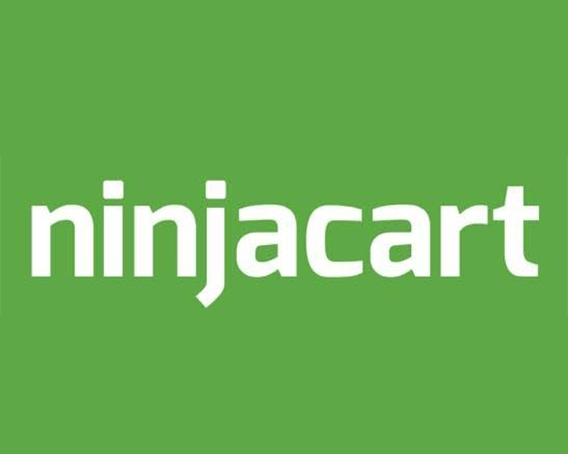

## Problem Statement

Ninjacart is India's largest produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver then to business within 12 hours. An integral component of their automation process is the development of robust classifier which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vetgetable as noise.

We have been tasked with preparing a multiclass classifier for identifying thes vegetables. 

## Data Collection
The images in this dataset were scrapped from Google.

## Content 
This dataset contains a folder train, which has a total of 3135 images, split into four folders as follows:
- Tomato : 789
- Potato : 898
- Onion : 849
- Indian Market : 599

This dataset contains another folder test which has a total of 351 images, split into 4 folders
- Tomato : 106
- Potato : 83
- Onion : 81
- Indian Market : 81

## Importing libraries

In [217]:
import os
import glob
import shutil
import random 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
tf.keras.utils.set_random_seed(55)
import warnings
warnings.filterwarnings('ignore')

In [172]:
class_dirs = os.listdir('ninjacart_data/train')
class_dirs

['indian market', 'onion', 'potato', 'tomato']

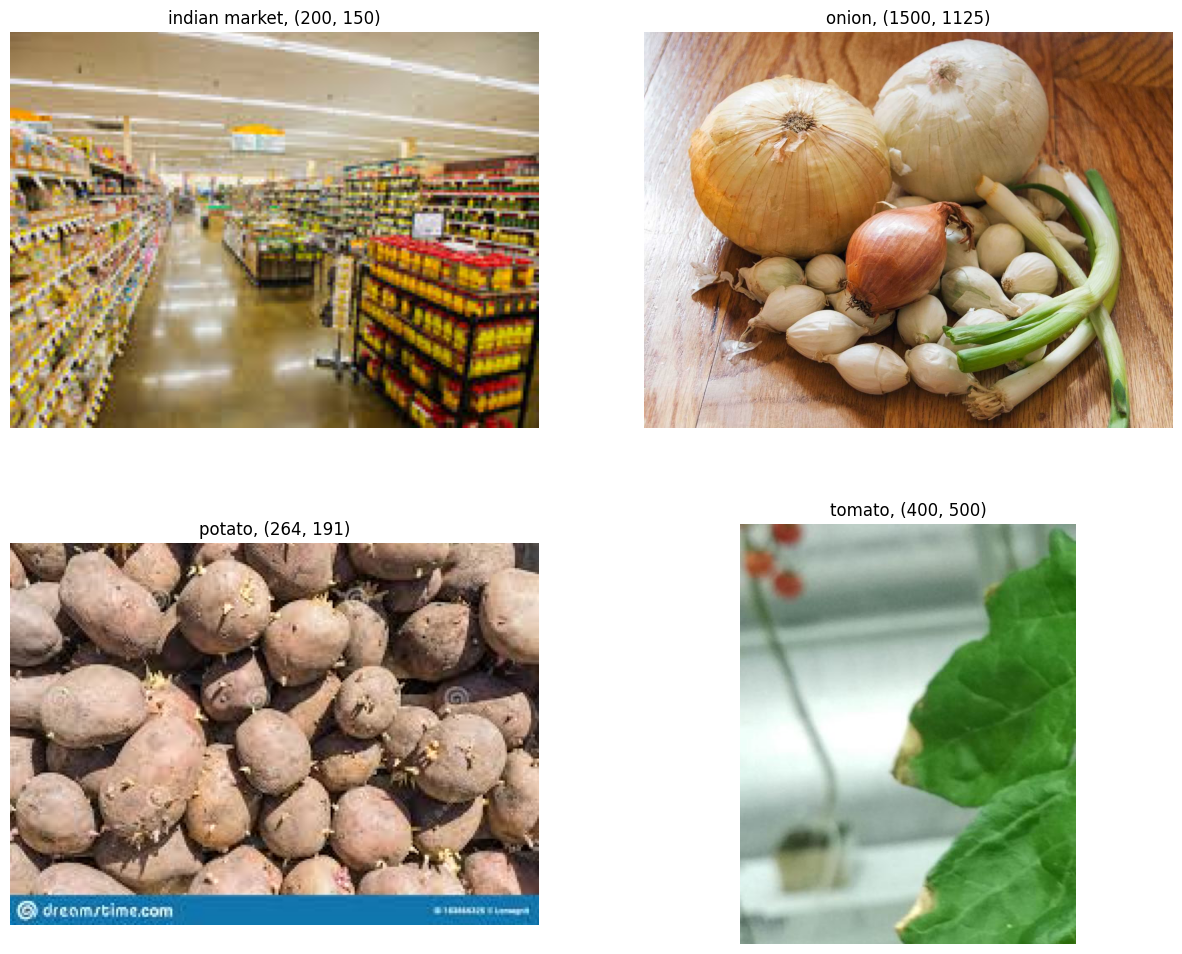

In [173]:
image_dict = {}
count_dict = {}
for cls in class_dirs:
    file_paths = glob.glob(f'ninjacart_data/train/{cls}/*')
    count_dict[cls] = len(file_paths)
    image_path = random.choice(file_paths)
    image_dict[cls] = tf.keras.utils.load_img(image_path)

plt.figure(figsize = (15,12))
for i,(cls,img) in enumerate(image_dict.items()):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(f'{cls}, {img.size}')
    plt.axis('off')

In [174]:
test_image_count = {}
for cls in class_dirs:
    filepath = glob.glob(f'ninjacart_data/test/{cls}/*')
    test_image_count[cls] = len(filepath)
test_image_count

{'indian market': 81, 'onion': 83, 'potato': 81, 'tomato': 106}

In [175]:
df_count_train = pd.DataFrame({
    'class':count_dict.keys(),
    'count':count_dict.values()
})
df_count_test = pd.DataFrame({
    'class':test_image_count.keys(),
    'count':test_image_count.values()
})

In [176]:
print(df_count_train)
print(df_count_test)

           class  count
0  indian market    599
1          onion    849
2         potato    898
3         tomato    789
           class  count
0  indian market     81
1          onion     83
2         potato     81
3         tomato    106


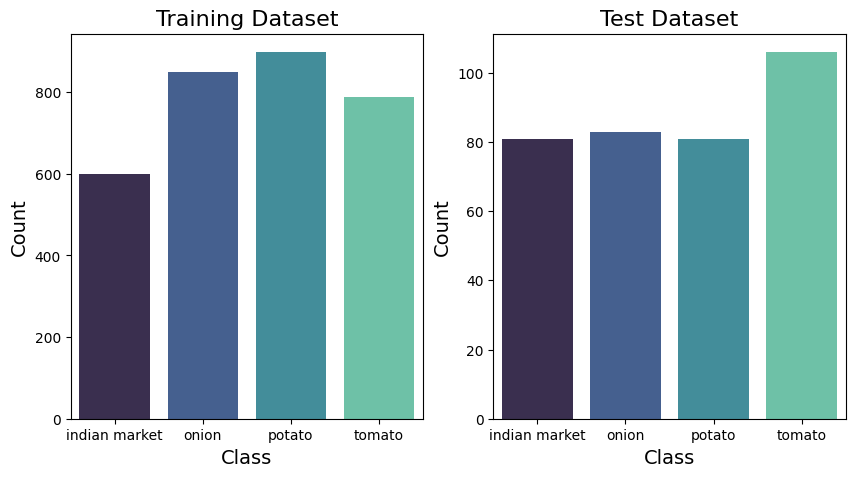

In [177]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.barplot(data = df_count_train,x='class',y = 'count',palette = 'mako')
plt.title('Training Dataset',fontsize = 16)
plt.xlabel('Class',fontsize = 14)
plt.ylabel('Count',fontsize = 14)
plt.subplot(1,2,2)
sns.barplot(data = df_count_test,x = 'class',y = 'count',palette = 'mako')
plt.title('Test Dataset',fontsize = 16)
plt.xlabel('Class',fontsize = 14)
plt.ylabel('Count',fontsize = 14)
plt.show()

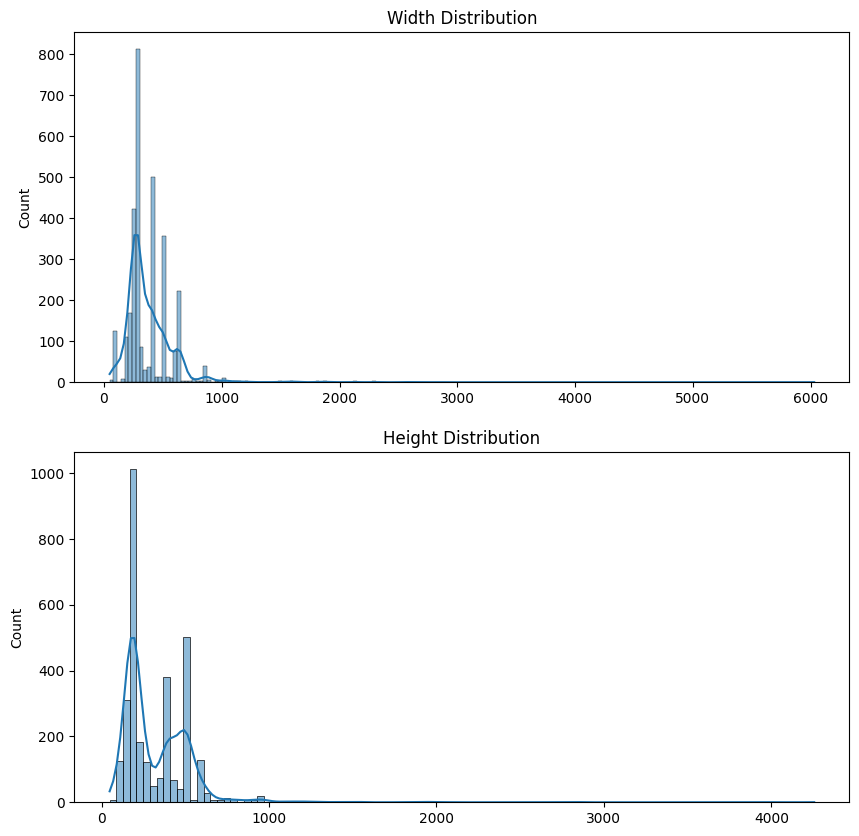

In [218]:
image_shape = []
for cls in class_dirs:
    category_path = os.path.join(source_folder,cls)
    images = os.listdir(category_path)
    for img in images:
        img_path = os.path.join(category_path,img)
        img = Image.open(img_path)
        image_shape.append(img.size)

#Plotting image dimensions
dims = np.array(image_shape)
plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
sns.histplot(dims[:,0],kde = True)
plt.title('Width Distribution')

plt.subplot(2,1,2)
sns.histplot(dims[:,1],kde = True)
plt.title('Height Distribution')
plt.show()

## Splitting the folders into train and validation sets

In [178]:
source_folder = r"D:\Scaler\Computer Vision\ninjacart\ninjacart_data\train"
validation_folder = r"D:\Scaler\Computer Vision\ninjacart\ninjacart_data\validation"
train_folder = r"D:\Scaler\Computer Vision\ninjacart\ninjacart_data\train_data"
test_folder = r"D:\Scaler\Computer Vision\ninjacart\ninjacart_data\test"

In [179]:
os.mkdir(validation_folder)

In [180]:
os.mkdir(train_folder)

In [181]:
for cls in class_dirs:
    class_folders = os.path.join(train_folder,cls)
    os.mkdir(class_folders)
    print(class_folders)

'for cls in class_dirs:\n    class_folders = os.path.join(train_folder,cls)\n    os.mkdir(class_folders)\n    print(class_folders)'

In [182]:
for cls in class_dirs:
    class_folders = os.path.join(validation_folder,cls)
    os.mkdir(class_folders)
    print(class_folders)

'for cls in class_dirs:\n    class_folders = os.path.join(validation_folder,cls)\n    os.mkdir(class_folders)\n    print(class_folders)'

In [183]:
image_dict ={}
for cls in class_dirs:
    file_paths = glob.glob(f'ninjacart_data/train/{cls}/*')
    image_dict[cls] = file_paths
    print(cls,len(file_paths))

indian market 599
onion 849
potato 898
tomato 789


In [184]:
for cls in class_dirs:
    for i in range(len(image_dict[cls])-100):
        src_path = image_dict[cls][i]
        file_name = src_path.split('\\')[-1]
        dst_path = os.path.join(train_folder,cls,file_name)
        shutil.copy(src_path,dst_path)
    for j in range(i+1,len(image_dict[cls])):
        src_path = image_dict[cls][j]
        file_name = src_path.split('\\')[-1]
        dst_path = os.path.join(validation_folder,cls,file_name)
        shutil.copy(src_path,dst_path)

"for cls in class_dirs:\n    for i in range(len(image_dict[cls])-100):\n        src_path = image_dict[cls][i]\n        file_name = src_path.split('\\')[-1]\n        dst_path = os.path.join(train_folder,cls,file_name)\n        shutil.copy(src_path,dst_path)\n    for j in range(i+1,len(image_dict[cls])):\n        src_path = image_dict[cls][j]\n        file_name = src_path.split('\\')[-1]\n        dst_path = os.path.join(validation_folder,cls,file_name)\n        shutil.copy(src_path,dst_path)"

## Data Preprocessing

In [187]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data generators with rescaling
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_datagen = ImageDataGenerator(rescale = 1./255,)
validation_generator = train_datagen.flow_from_directory(
    validation_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    #subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 2191 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


## Defining the CNN Classifier model from scratch

In [188]:
def create_cnn_model():
    model = Sequential(
        [
        Conv2D(16,(3,3),padding = 'same',activation = 'relu',
                      input_shape = (128,128,3)),
        MaxPooling2D(),
        Conv2D(filters = 32,kernel_size = 3,padding = 'same',
                     activation = 'relu'),
        MaxPooling2D(),
        Conv2D(filters = 64,kernel_size = 3,padding = 'same',
                     activation = 'relu'),
        MaxPooling2D(),
        Conv2D(filters = 128,kernel_size = 3,padding = 'same',
                     activation = 'relu'),
        MaxPooling2D(),
        Conv2D(filters = 256,kernel_size = 3,padding = 'same',
                     activation = 'relu'),
        GlobalAveragePooling2D(),
        Dense(units = 256,activation = 'relu'),
        Dense(units = 4,activation = 'softmax')
        ]
    )
    model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
    return model

#Create models
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_145 (Conv2D)                  │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_116 (MaxPooling2D)     │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_146 (Conv2D)                  │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_117 (MaxPooling2D)     │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_147 (Conv2D)                  │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_118 (MaxPooling2D)     │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_148 (Conv2D)                  │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_119 (MaxPooling2D)     │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_149 (Conv2D)                  │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_91          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_182 (Dense)                    │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 459,428 (1.75 MB)

 Trainable params: 459,428 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [190]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
def create_transfer_learning_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512,activation = 'relu'),
        Dropout(0.5),
        Dense(4,activation = 'softmax')
    ])
    model.compile(optimizer = Adam(),loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model
#Create models
cnn_model = create_cnn_model()
vgg_model = create_transfer_learning_model(VGG16(include_top = False,
                                                 input_shape=(128,128,3)))
resnet_model = create_transfer_learning_model(ResNet50(include_top=False,
                                                       input_shape=(128, 128, 3)))
mobilenet_model = create_transfer_learning_model(MobileNetV2(include_top=False,
                                                             input_shape=(128, 128, 3)))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights = True)
model_checkpoint_cnn = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, 
                                       monitor='val_loss')
model_checkpoint_vgg = ModelCheckpoint('best_vgg_model.keras', save_best_only=True, 
                                       monitor='val_loss')
model_checkpoint_resnet = ModelCheckpoint('best_resnet_model.keras', save_best_only=True, 
                                          monitor='val_loss')
model_checkpoint_mobilenet = ModelCheckpoint('best_mobilenet_model.keras', 
                                             save_best_only=True, monitor='val_loss')
tensorboard = TensorBoard(log_dir='./logs')

In [191]:
# Training models
history_cnn = cnn_model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    callbacks = [early_stopping,model_checkpoint_cnn,tensorboard]
)
history_vgg = vgg_model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    callbacks = [early_stopping,model_checkpoint_vgg,tensorboard]
)
history_resnet = resnet_model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    callbacks = [early_stopping,model_checkpoint_resnet,tensorboard]
)
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    callbacks = [early_stopping,model_checkpoint_mobilenet,tensorboard]
)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.4750 - loss: 1.1076 - val_accuracy: 0.6800 - val_loss: 0.7892
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.7284 - loss: 0.6830 - val_accuracy: 0.7550 - val_loss: 0.6045
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - accuracy: 0.8089 - loss: 0.5110 - val_accuracy: 0.7700 - val_loss: 0.6106
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 27s 359ms/step - accuracy: 0.8408 - loss: 0.4227 - val_accuracy: 0.7500 - val_loss: 0.6409
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 392ms/step - accuracy: 0.8034 - loss: 0.4957 - val_accuracy: 0.7800 - val_loss: 0.5323
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 351ms/step - accuracy: 0.8458 - loss: 0.4037 - val_accuracy: 0.7875 - val_loss: 0.5669
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 383ms/step - accuracy: 0.8366 - loss: 0.4204 - val_accuracy: 0.8075 - val_loss: 0.4631
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 352ms/step - accuracy: 0.8644 - loss: 0.3610 - val_accu

## Evaluate on test data

In [192]:
#Load the models
best_cnn_model = tf.keras.models.load_model('best_cnn_model.keras')
best_vgg_model = tf.keras.models.load_model('best_vgg_model.keras')
best_resnet_model = tf.keras.models.load_model('best_resnet_model.keras')
best_mobilenet_model = tf.keras.models.load_model('best_mobilenet_model.keras')

#Evaluate on test data
cnn_test_loss,cnn_test_acc = best_cnn_model.evaluate(test_generator)
vgg_test_loss,vgg_test_acc = best_vgg_model.evaluate(test_generator)
resnet_test_loss,resnet_test_acc = best_resnet_model.evaluate(test_generator)
mobilenet_test_loss,mobilenet_test_acc = best_mobilenet_model.evaluate(test_generator)

print('Test Accuracy of CNN :',cnn_test_acc)
print('Test Accuracy of VGG :',vgg_test_acc)
print('Test Accuracy of ResNet : ',resnet_test_acc)
print('Test Accuracy of MobileNet : ',mobilenet_test_acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.8634 - loss: 0.3302
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8047 - loss: 0.5497
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 483ms/step - accuracy: 0.3956 - loss: 1.1961
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.8684 - loss: 0.5108
Test Accuracy of CNN : 0.8347578644752502
Test Accuracy of VGG : 0.8062677979469299
Test Accuracy of ResNet :  0.43589743971824646
Test Accuracy of MobileNet :  0.8774929046630859


## Plotting training accuracy and validation accuracy

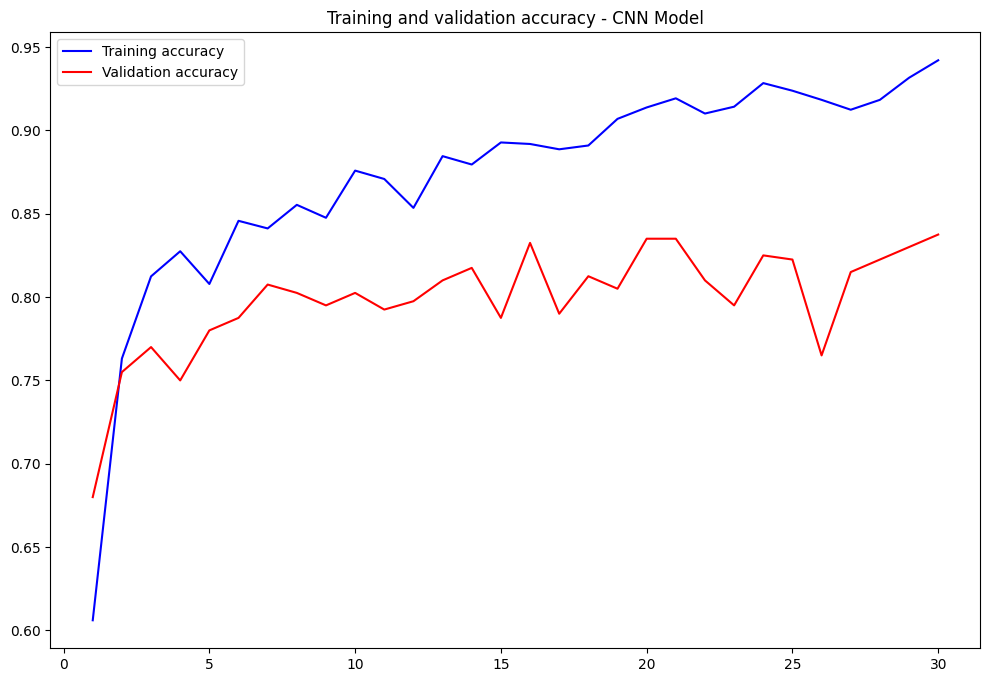

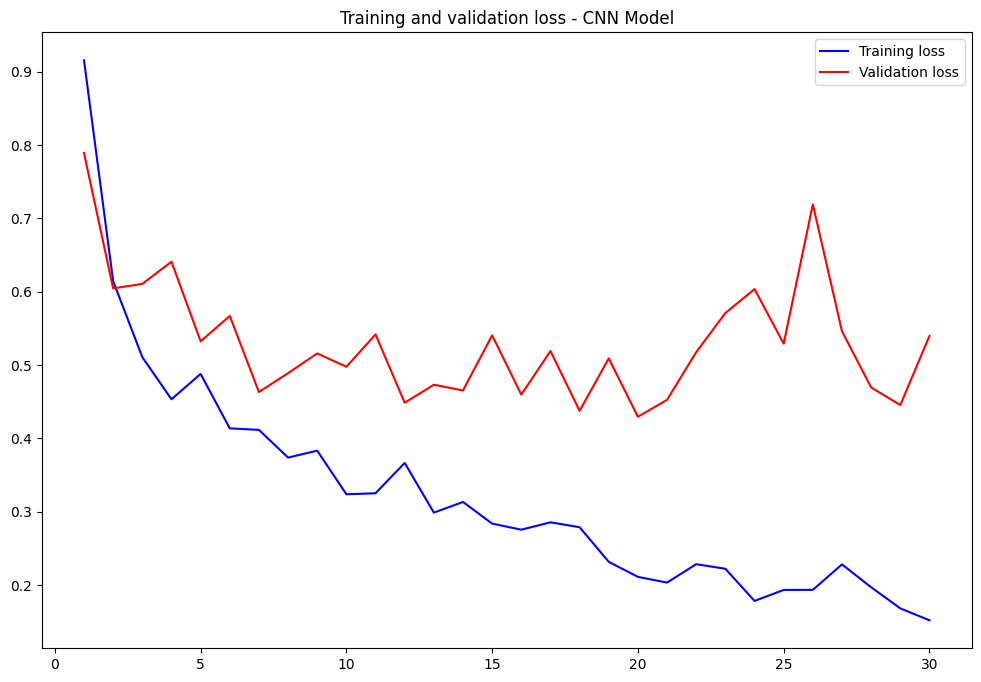

In [194]:
def plot_training_accuracy(model_fit,title):
    acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    loss = model_fit.history['loss']
    val_loss = model_fit.history['val_loss']
    epochs = range(1,len(acc)+1)

    plt.figure(figsize = (12,8))
    plt.plot(epochs, acc ,'b',label = 'Training accuracy')
    plt.plot(epochs,val_acc,'r',label = 'Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.legend()

    plt.figure(figsize = (12,8))
    plt.plot(epochs,loss,'b',label = 'Training loss')
    plt.plot(epochs,val_loss,'r',label = 'Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.legend()
    plt.show()
plot_training_accuracy(history_cnn,'CNN Model')

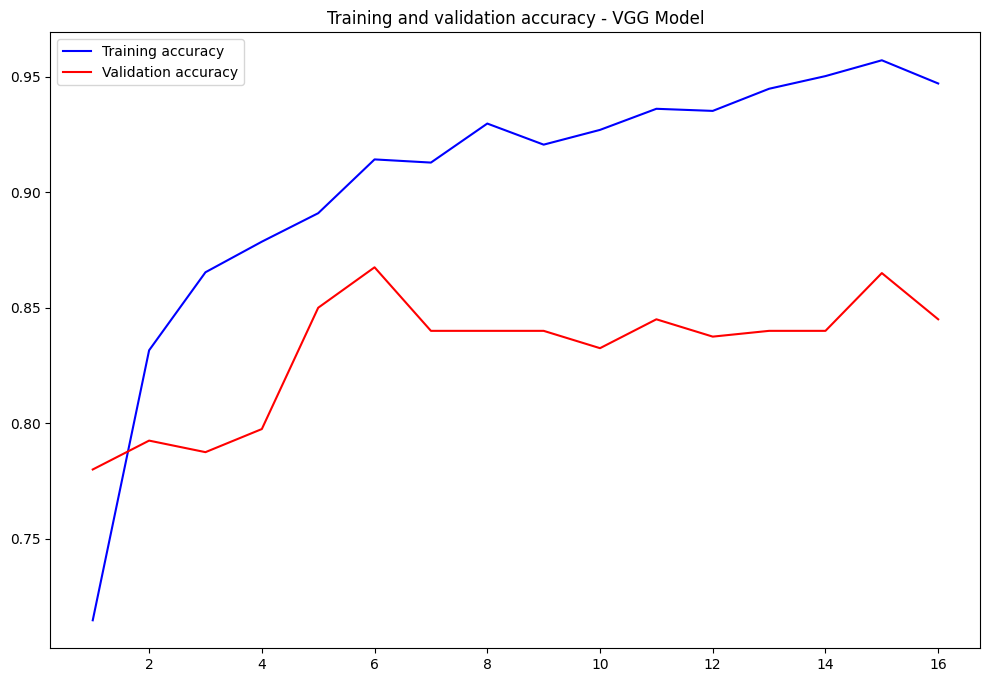

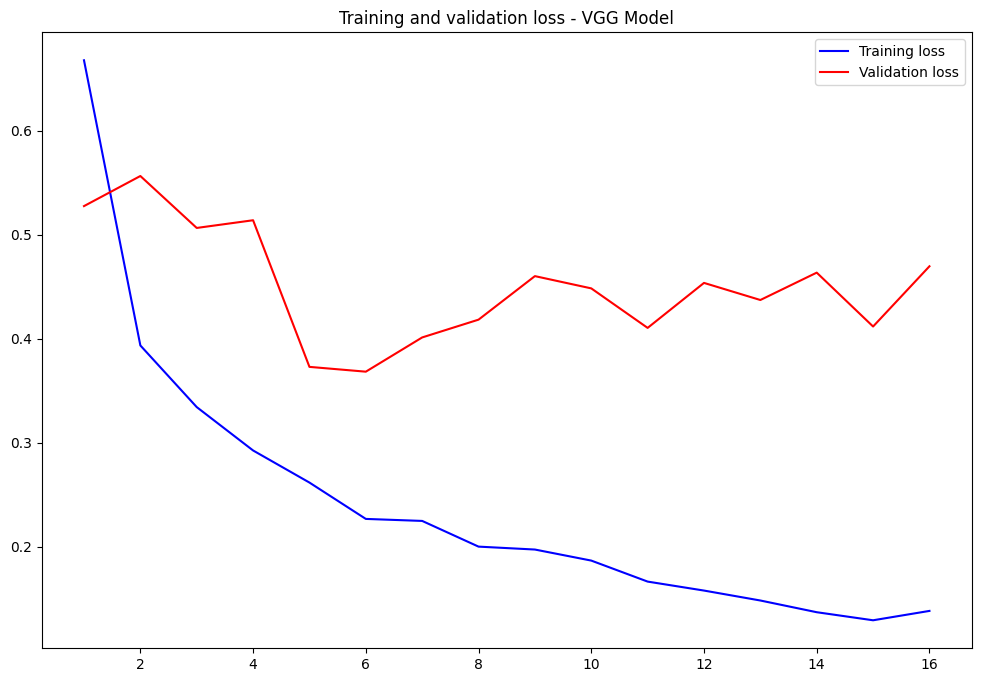

In [196]:
plot_training_accuracy(history_vgg, 'VGG Model')

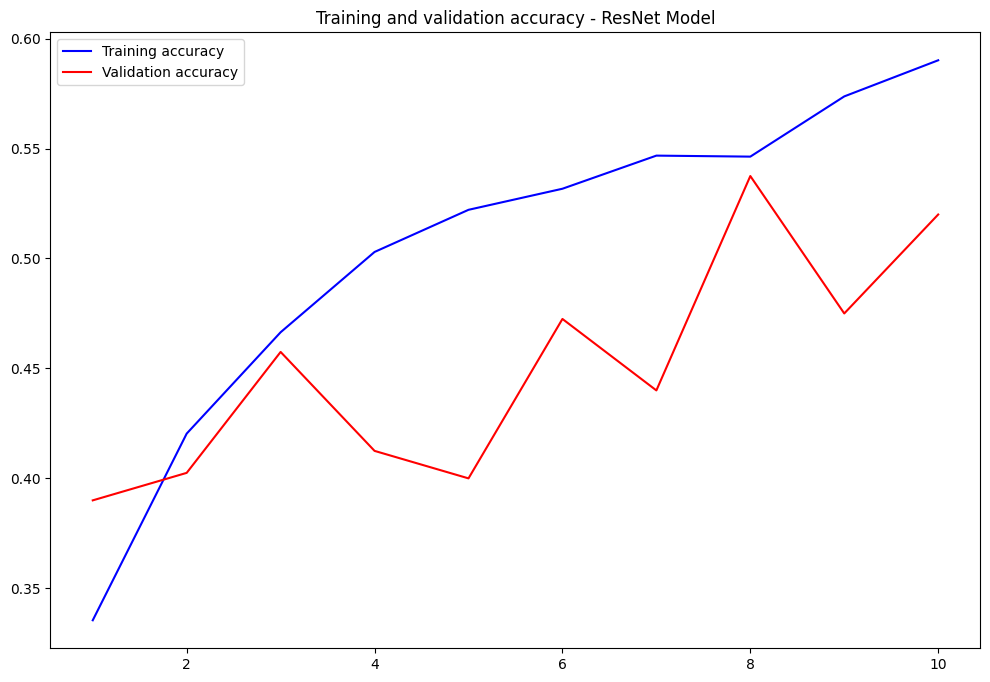

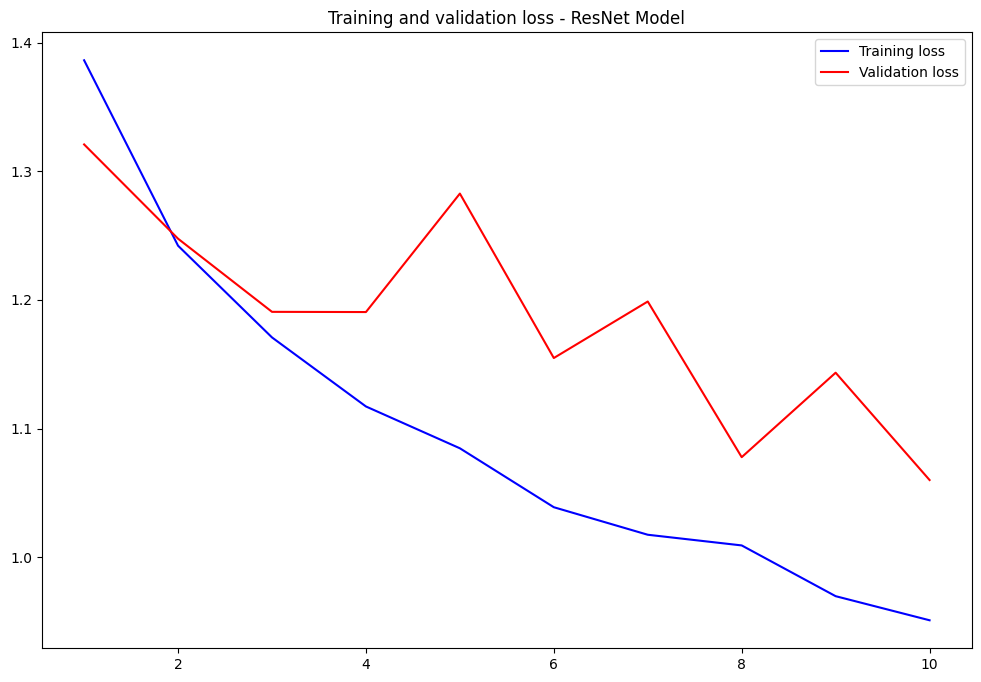

In [197]:
plot_training_accuracy(history_resnet, 'ResNet Model')

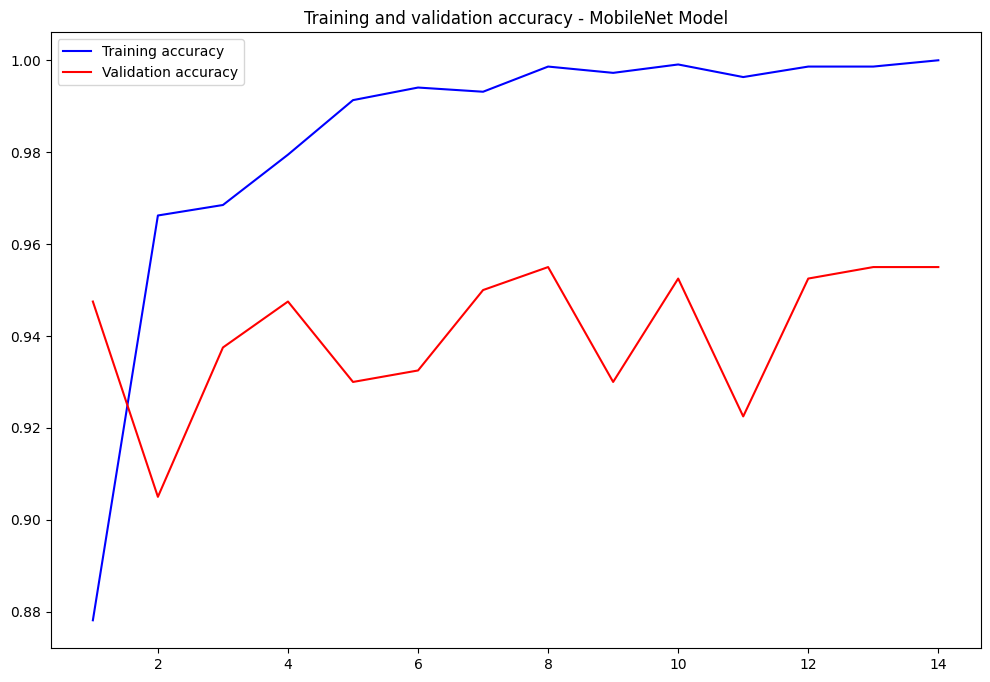

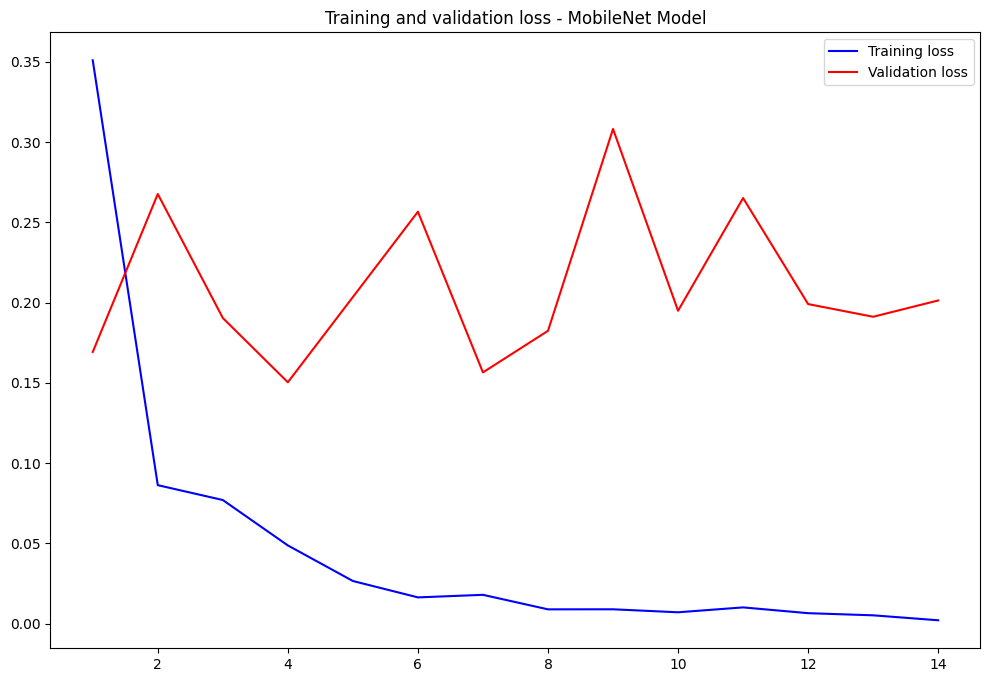

In [198]:
plot_training_accuracy(history_mobilenet, 'MobileNet Model')

## Confusion Matices

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


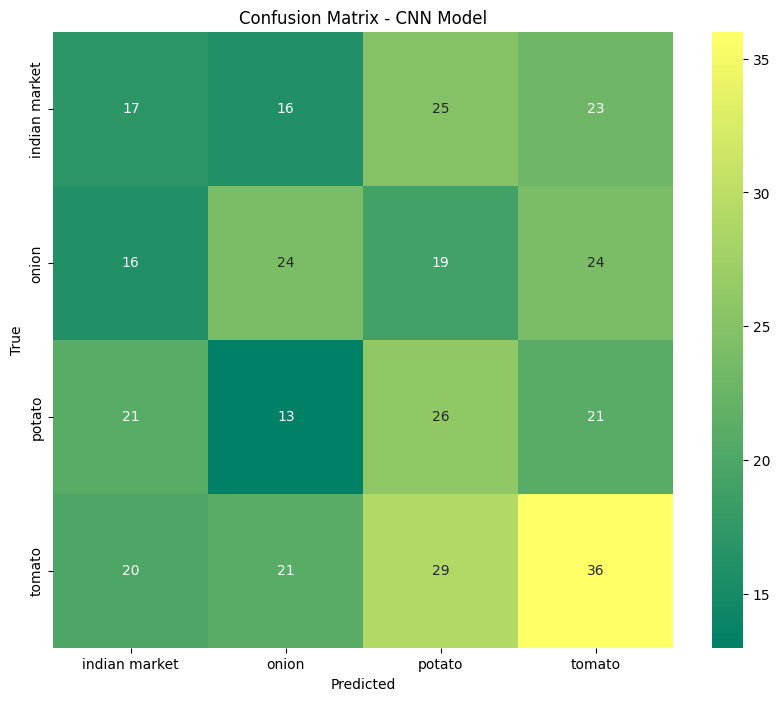

In [208]:
def plot_confusion_matrix(model,title):
    categories = class_dirs
    test_generator.reset()
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred,axis = 1)

    cm = confusion_matrix(test_generator.classes,y_pred)
    plt.figure(figsize = (10,8))
    sns.heatmap(cm,annot = True,fmt = 'd',cmap = 'summer',
                xticklabels = categories,yticklabels = categories )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

plot_confusion_matrix(best_cnn_model,'CNN Model')

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


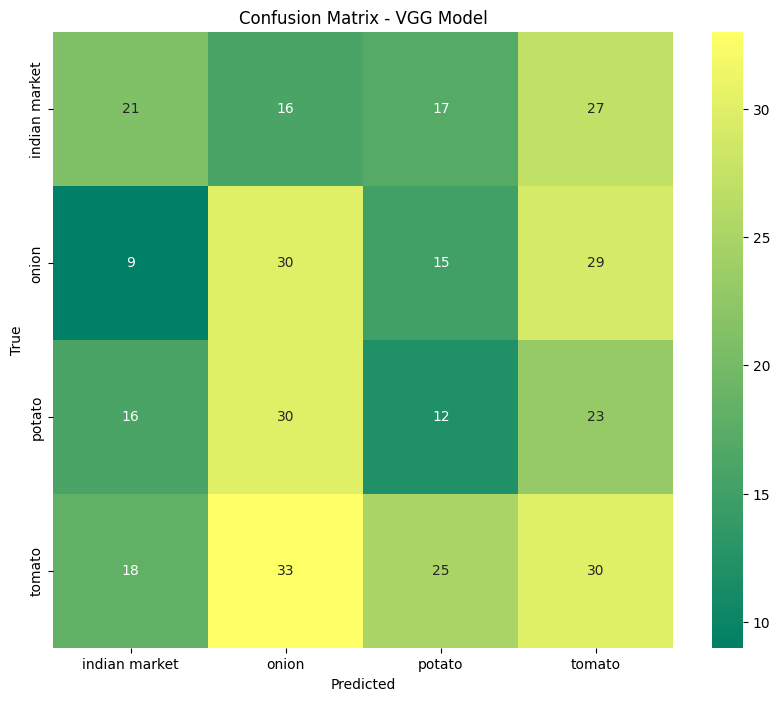

In [209]:
plot_confusion_matrix(best_vgg_model, 'VGG Model')

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 637ms/step


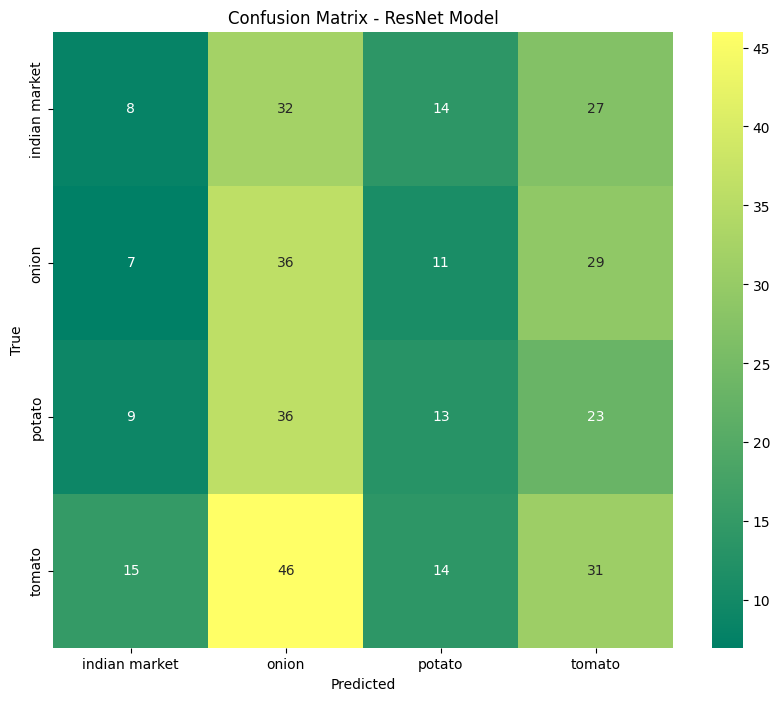

In [210]:
plot_confusion_matrix(best_resnet_model, 'ResNet Model')

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step


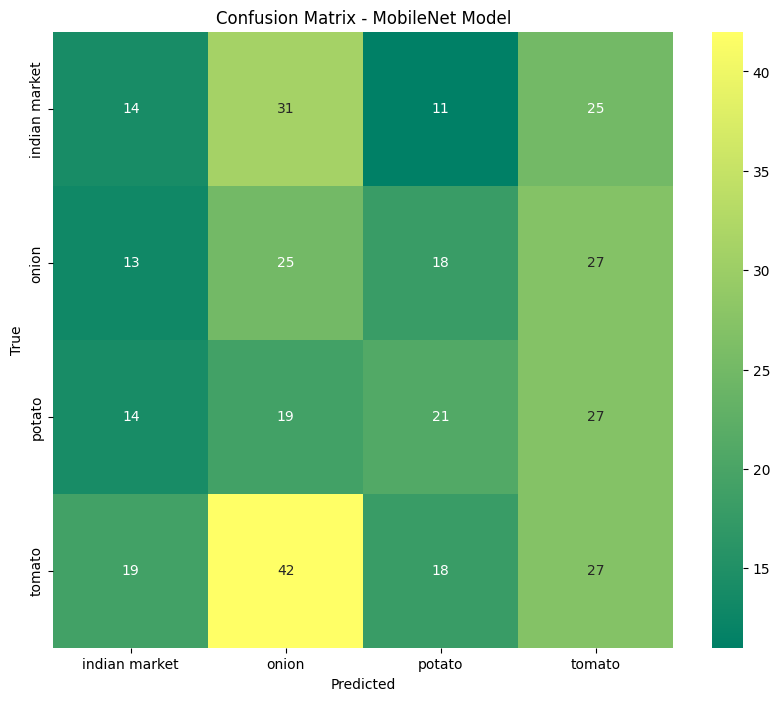

In [211]:
plot_confusion_matrix(best_mobilenet_model, 'MobileNet Model')

In [212]:
def evaluate_model(model, title):
    categories = class_dirs
    test_generator.reset()
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    print(f'Classification Report - {title}')
    print(classification_report(test_generator.classes, y_pred, target_names=categories))

# Evaluate models
evaluate_model(best_cnn_model, 'CNN Model')
evaluate_model(best_vgg_model, 'VGG Model')
evaluate_model(best_resnet_model, 'ResNet Model')
evaluate_model(best_mobilenet_model, 'MobileNet Model')

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Classification Report - CNN Model
               precision    recall  f1-score   support

indian market       0.24      0.22      0.23        81
        onion       0.14      0.12      0.13        83
       potato       0.21      0.26      0.23        81
       tomato       0.29      0.28      0.29       106

     accuracy                           0.23       351
    macro avg       0.22      0.22      0.22       351
 weighted avg       0.22      0.23      0.22       351

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Classification Report - VGG Model
               precision    recall  f1-score   support

indian market       0.19      0.15      0.17        81
        onion       0.20      0.27      0.23        83
       potato       0.32      0.27      0.29        81
       tomato       0.28      0.29      0.29       106

     accuracy                           0.25       351
    macro avg       0.25      0.24      0.24       351
 weighted avg       0.

In [213]:
# Accuracy of each model
model_accuracies = {
    'CNN': cnn_test_acc,
    'VGG': vgg_test_acc,
    'ResNet': resnet_test_acc,
    'MobileNet': mobilenet_test_acc
}

# Print the accuracies
for model_name, accuracy in model_accuracies.items():
    print(f'Test Accuracy - {model_name}: {accuracy}')

# Based on the printed accuracies, we can identify the model with the highest accuracy
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model_accuracy = model_accuracies[best_model_name]
print(f'The best-performing model is {best_model_name} with an accuracy of {best_model_accuracy}')


Test Accuracy - CNN: 0.8347578644752502
Test Accuracy - VGG: 0.8062677979469299
Test Accuracy - ResNet: 0.43589743971824646
Test Accuracy - MobileNet: 0.8774929046630859
The best-performing model is MobileNet with an accuracy of 0.8774929046630859


## Final Summary and Insights

After evaluating and comparing all models we found that 
- Mobilenet had the highest accuracy 
- We found that pre trained models have high accuracy, because of the deep cnn architecture.
- To handle overfitting 
    - We add BatchNormalization and Dropout layers to the architecture.
    - We can do hyperparameter training choosing the best parameters for the model.
    - We can perform data augmentation to improve the model's generalization.

In [214]:
# Assuming the evaluations have been printed and confusion matrices displayed
print("Summary and Insights:")
print(f"The best-performing model is {best_model_name} with a test accuracy of {best_model_accuracy:.2f}.")

# Discuss further based on precision, recall, F1-score
# For example:
if best_model_name == 'ResNet':
    print("ResNet shows a high accuracy and balanced performance across all classes, making it the most reliable model for this task.")
elif best_model_name == 'VGG':
    print("VGG performs well but may slightly lag in recall for certain classes compared to ResNet.")
# Continue with insights based on detailed classification reports and confusion matrices


Summary and Insights:
The best-performing model is MobileNet with a test accuracy of 0.88.
